In [1]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load and describe

In [2]:
df = pd.read_csv("in-vehicle-coupon-recommendation.csv")
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

# Preprocessing dataset

## Check for NaN

In [4]:
df_na_sum = df.isna().sum()
df_na_sum[df_na_sum > 0]/len(df)

car                     0.991485
Bar                     0.008436
CoffeeHouse             0.017108
CarryAway               0.011905
RestaurantLessThan20    0.010249
Restaurant20To50        0.014901
dtype: float64

## Drop `car` column since it has 99% `NaN`

In [5]:
df.drop('car', axis=1, inplace=True)
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


## Drop 'NaN' from 'CarryAway' and 'RestaurantLessThan20' because they don't allow 'NaN' and take a small percentage of the dataset.

In [6]:
df.dropna(subset=["CarryAway", "RestaurantLessThan20"], inplace=True)
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
22,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,1
23,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,0
24,No Urgent Place,Friend(s),Sunny,80,10AM,Bar,1d,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,1
25,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Male,21,Single,...,less1,4~8,4~8,less1,1,1,0,0,1,0
26,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


## Change all **object** columns to **category**

In [7]:
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].astype("category")
df

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
22,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,1
23,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,0
24,No Urgent Place,Friend(s),Sunny,80,10AM,Bar,1d,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,1
25,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Male,21,Single,...,less1,4~8,4~8,less1,1,1,0,0,1,0
26,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Male,21,Single,...,less1,4~8,4~8,less1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


In [8]:
df["Y"].value_counts(normalize=True)

1    0.566412
0    0.433588
Name: Y, dtype: float64

In [9]:
df.dtypes

destination             category
passanger               category
weather                 category
temperature                int64
time                    category
coupon                  category
expiration              category
gender                  category
age                     category
maritalStatus           category
has_children               int64
education               category
occupation              category
income                  category
Bar                     category
CoffeeHouse             category
CarryAway               category
RestaurantLessThan20    category
Restaurant20To50        category
toCoupon_GEQ5min           int64
toCoupon_GEQ15min          int64
toCoupon_GEQ25min          int64
direction_same             int64
direction_opp              int64
Y                          int64
dtype: object

In [10]:
import seaborn as sns

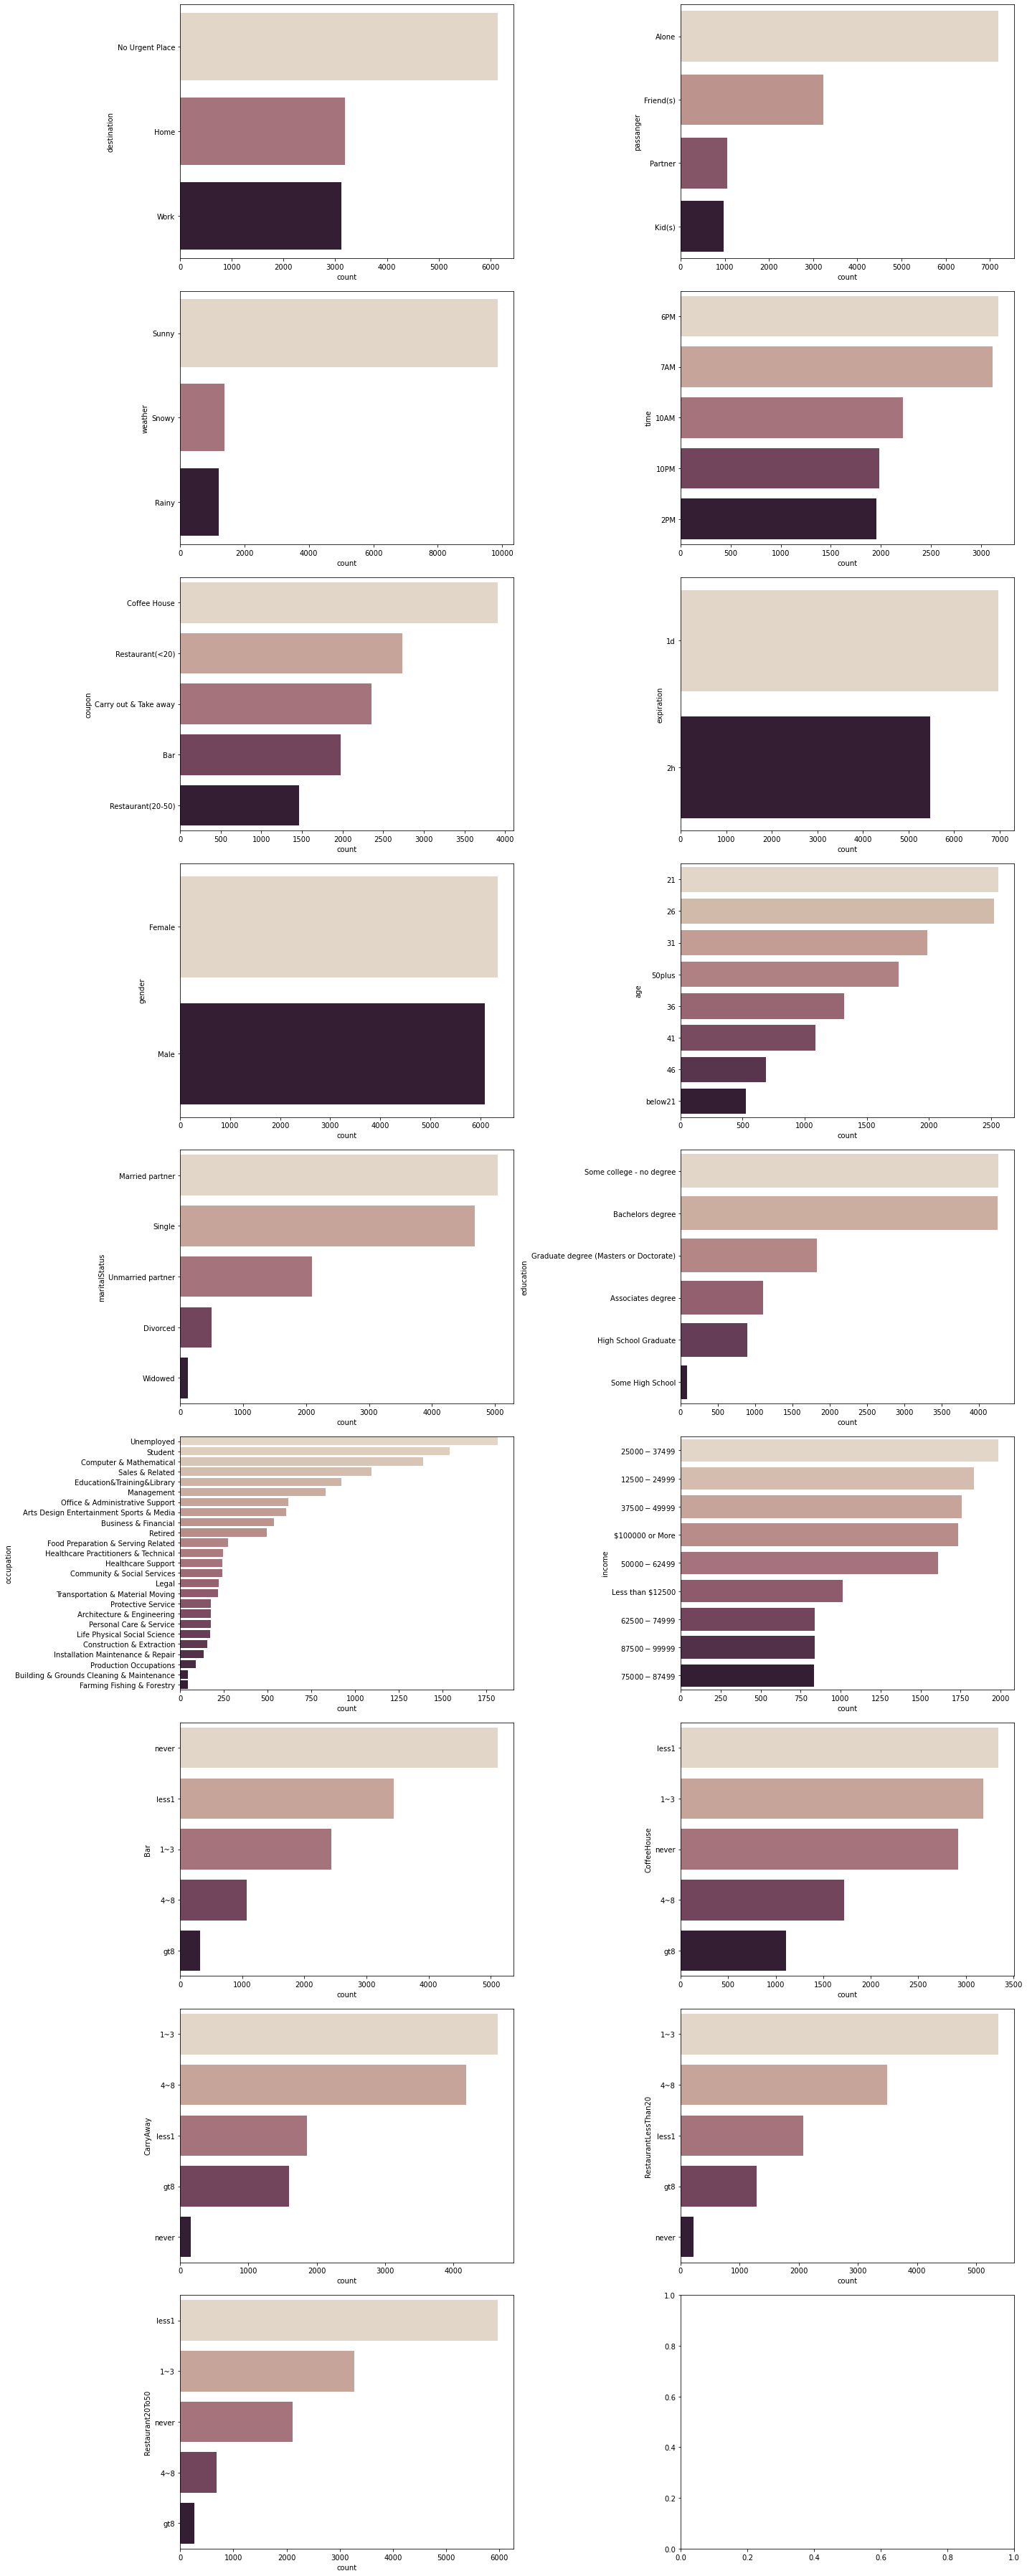

In [11]:
fig, axes = plt.subplots(9, 2, figsize=(20,50))
axes = axes.flatten()

for ax, col in zip(axes, df.select_dtypes('category').columns):
    sns.countplot(y=col, data=df, ax=ax, 
                  palette="ch:.25", order=df[col].value_counts().index);

plt.tight_layout()
plt.show()

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
x = df.drop('Y', axis=1)
y = df['Y']

ohe = OneHotEncoder(sparse=False)
x = pd.DataFrame(ohe.fit_transform(x), index=y.index, columns=ohe.get_feature_names(x.columns))


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [15]:
from sklearn.model_selection import StratifiedKFold

# Split data for train and test (k-fold)

In [16]:
kf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=7
)

# Building and evaluating model

## Random Forest classifier

In [17]:
rfc = RandomForestClassifier(
    max_depth=7,
    min_samples_split=5,
    random_state=7
)

rfc_acc = 0
rfc_cfm = np.zeros((2, 2))

for train_index, test_index in kf.split(x,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rfc.fit(x_train, y_train)
    y_pred = rfc.predict(x_test)
    rfc_acc = rfc_acc + accuracy_score(y_test, y_pred)
    rfc_cfm = rfc_cfm + confusion_matrix(y_test, y_pred)

TRAIN: [    0     3     4 ... 12439 12441 12442] TEST: [    1     2     8 ... 12440 12443 12444]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    4    24    27 ... 12425 12431 12437]
TRAIN: [    0     1     2 ... 12442 12443 12444] TEST: [    6    12    14 ... 12417 12423 12439]
TRAIN: [    1     2     3 ... 12442 12443 12444] TEST: [    0     5    11 ... 12433 12434 12441]
TRAIN: [    0     1     2 ... 12441 12443 12444] TEST: [    3     7    10 ... 12428 12432 12442]


## Average accuracy score

In [18]:
rfc_acc/kf.get_n_splits()

0.707593411008437

In [19]:
parameters = {
    'n_estimators': [400,450,500],
               'criterion':['gini','entropy'],
                    'max_depth': [15, 20, 25],
                        'min_samples_split': [2,3],
}

In [20]:
from sklearn.model_selection import GridSearchCV 

In [51]:
# create the grid
n_estimators = [10, 100, 200]
max_depth = [7,15,11]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)

In [52]:
# create the default model
rf = RandomForestClassifier()

# search the grid
grid = GridSearchCV(estimator=rf, 
                    param_grid=param_grid,
                    cv=10,
                    verbose=2,
                    n_jobs=-1)

grid_result = grid.fit(x_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


In [53]:
from sklearn.metrics import classification_report

In [54]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.37      0.41      1080
           1       0.58      0.66      0.61      1409

    accuracy                           0.53      2489
   macro avg       0.51      0.51      0.51      2489
weighted avg       0.52      0.53      0.52      2489



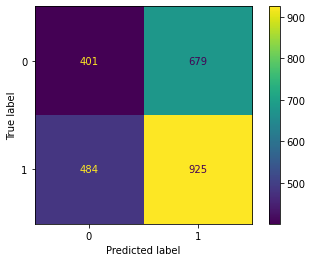

In [56]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(grid, X_test, y_test)

In [25]:
grid_result.best_estimator_

RandomForestClassifier(max_depth=11, n_estimators=200)

In [26]:
grid_result.best_params_

{'max_depth': 11, 'n_estimators': 200}

In [27]:
grid_result.best_score_

0.6920434501826402

In [28]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.692043 using {'max_depth': 11, 'n_estimators': 200}
0.668640 (0.020862) with: {'max_depth': 7, 'n_estimators': 10}
0.681803 (0.013168) with: {'max_depth': 7, 'n_estimators': 100}
0.681099 (0.013346) with: {'max_depth': 7, 'n_estimators': 200}
0.654176 (0.020729) with: {'max_depth': 15, 'n_estimators': 10}
0.688528 (0.026747) with: {'max_depth': 15, 'n_estimators': 100}
0.688527 (0.022319) with: {'max_depth': 15, 'n_estimators': 200}
0.669846 (0.018704) with: {'max_depth': 11, 'n_estimators': 10}
0.689734 (0.018597) with: {'max_depth': 11, 'n_estimators': 100}
0.692043 (0.019794) with: {'max_depth': 11, 'n_estimators': 200}


<AxesSubplot:>

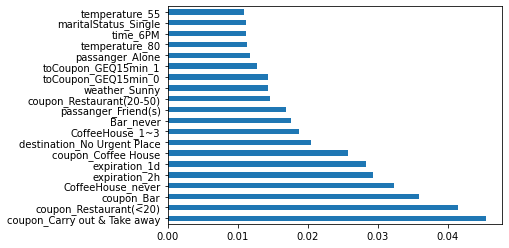

In [29]:
rf_eature = grid.best_estimator_.fit(x_train,y_train)
feat_importances = pd.Series(rf_eature.feature_importances_, index=x_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

In [32]:
logreg = LogisticRegression(random_state=111)
clf = GridSearchCV(logreg,                   
                   param_grid = parameters,  
                   scoring='accuracy',        
                   cv=10)                    

In [33]:
clf.fit(x_train,y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=111),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [34]:
print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.6703497406712277


In [35]:
y_pred = clf.predict(x_test)

In [36]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.680996384089996


In [37]:
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      0.38      0.41      1080
           1       0.57      0.64      0.61      1409

    accuracy                           0.53      2489
   macro avg       0.51      0.51      0.51      2489
weighted avg       0.52      0.53      0.52      2489



In [38]:
from sklearn.neighbors import KNeighborsClassifier

In [39]:
parameters = {'n_neighbors' : [7,2,9],
              'p' : [1,9],
           "weights": ["uniform", "distance"]}

In [40]:
## Confusion matrix

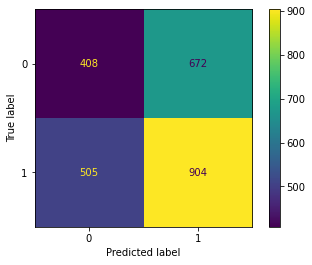

In [41]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(grid, X_test, y_test)

In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [43]:
gnb = GaussianNB()
cv = cross_val_score(gnb,X_train,y_train,cv=10)
print(cv)
print(cv.mean())

[0.48493976 0.48895582 0.44277108 0.48795181 0.47590361 0.51204819
 0.49045226 0.48643216 0.49547739 0.50954774]
0.48744798288631913


In [44]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =5)
cv = cross_val_score(xgb,X_train,y_train,cv=10)
print(cv)
print(cv.mean())


[nan nan nan nan nan nan nan nan nan nan]
nan


In [45]:
#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    #print('Best Parameters: ' + str(classifier.best_params_)

In [46]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [49]:
xgb = XGBClassifier()

param_grid = {
    'n_estimators': [100,200],
    
    'max_depth': [5,9,11],
    
    'learning_rate':[0.1,0.01],

}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
XGB
Best Score: 0.5581554747367168


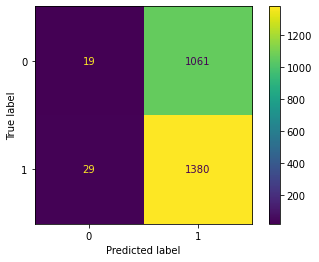

In [50]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf_xgb, X_test, y_test)